# Practical 5: Monte Carlo Methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as disp
import rldurham as rld

## **Setup**

Start with the small version, then switch to 8x8, which is much harder.

Seed set to 42


actions are discrete with 4 dimensions/#actions
observations are discrete with 16 dimensions/#observations
maximum timesteps is: 100


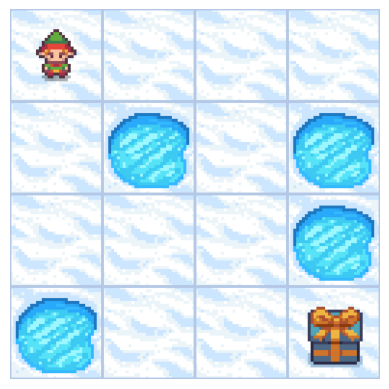

In [2]:
env = rld.make(
    'FrozenLake-v1',         # small version
    # 'FrozenLake8x8-v1',    # larger version
    # desc=["GFFS", "FHFH", "FFFH", "HFFG"],  # custom map
    render_mode="rgb_array", # for rendering as image/video
    is_slippery=False,       # warning: slippery=True results in complex dynamics
)
rld.env_info(env, print_out=True)
rld.seed_everything(42, env)
LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3
rld.render(env)

Helper class to keep track of experiments

In [3]:
class Experiment:
    def __init__(self, cmap='tab10'):
        # different colors for each experiment
        self.cmap = plt.colormaps.get_cmap(cmap)
        self.colors = self.cmap.colors
        
        # data for plotting
        self.reward_list = []
        self.plot_data = []
        self.plot_labels = []
        self.auc = []
        
        # data for experiments
        self.experiment_id = -1
        self.episode_idx = 0
    
    def new_experiment(self, plot_label=None):
        # increment/reset counter
        self.experiment_id += 1
        self.episode_idx = 0
        # initialise new plotting data for this experiment
        self.reward_list.append([])
        self.plot_data.append([])
        self.plot_labels.append(f"experiment #{self.experiment_id}" if plot_label is None else plot_label)
        self.auc.append(0)

    def finish_episode(self, reward_sum, plot_every=500):
        self.reward_list[self.experiment_id].append(reward_sum)
        self.auc[self.experiment_id] += int(reward_sum)
    
        if (self.episode_idx + 1) % plot_every == 0:
            self.plot_data[self.experiment_id].append([
                self.episode_idx,
                np.array(self.reward_list[self.experiment_id]).mean(),
                np.array(self.reward_list[self.experiment_id]).std()
            ])
            self.reward_list[self.experiment_id] = []
    
            for i in range(len(self.plot_data)):
                plt.plot([x[0] for x in self.plot_data[i]], [x[1] for x in self.plot_data[i]], '-',
                         # color=colors[i],
                         label=self.plot_labels[i] + ', AUC: '+str(self.auc[i]))
            plt.xlabel('Episode number')
            plt.ylabel('Episode reward')
            plt.legend()
            disp.clear_output(wait=True)
            plt.show()
        
        self.episode_idx += 1

exp = Experiment()

## **Monte carlo learning**

### 1) Constant exploration: **$\epsilon$-greedy**

### 2) Greedy at the limit with infinite exploration: **GLIE**

### 3) Optimism in the face of uncertainty: **UCB1 Policy**

### 4) Optimism in the face of uncertainty: **Exploration Bonus**

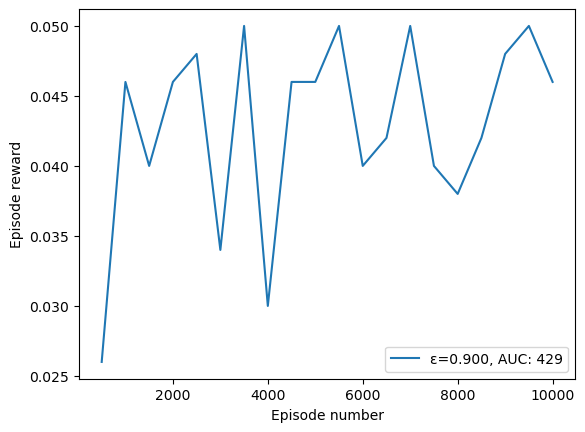

In [4]:
# init Q function and visit counts
Q = np.zeros([env.observation_space.n, env.action_space.n])
n_s_a = np.zeros([env.observation_space.n, env.action_space.n])

strategy = "ε-greedy"
# strategy = "GLIE"
# strategy = "UCB1"
# strategy = "bonus"

# initialise strategies
if strategy == "ε-greedy":
    epsilon = 0.9  #........................................CHANGE THIS
    exp.new_experiment(f"ε={epsilon:.3f}")
    Q += 1
    n_s_a += 1
elif strategy == "GLIE":
    exp.new_experiment("GLIE")
elif strategy == "UCB1":
    c = .1  #...............................................CHANGE THIS
    exp.new_experiment(f"UCB1: c={c}")
if strategy == "bonus":
    epsilon = 0  #..........................................CHANGE THIS
    Q_bonus = 1  #..........................................CHANGE THIS
    prior_counts = 1  #.....................................CHANGE THIS
    exp.new_experiment(f"bonus: ε={epsilon}, Q+={Q_bonus}, #={prior_counts}")
    Q += Q_bonus
    n_s_a += prior_counts

# perform experiment
for eidx in range(10000):
    state, info = env.reset()
    done = False
    episode = []
    while not done:
        # get action
        if strategy in ["ε-greedy", "GLIE", "bonus"]:
            if strategy == "GLIE":
                epsilon = min(1.0, 1500.0 / (eidx + 1))  #...CHANGE THIS
            if np.random.rand() > epsilon:
                action = np.argmax(Q[state, :])
            else:
                action = env.action_space.sample()
        elif strategy == "UCB1":
            if np.any(n_s_a[state] == 0):
                # first, try every action at least once
                action = np.random.choice(np.argwhere(n_s_a[state] == 0).flatten())
            else:
                # then, use upper bounds to choose actions
                R_s_a = Q[state, :]
                n_s_a_ = n_s_a[state]
                n_s = n_s_a_.sum()
                B_s_a = R_s_a + 2 * c * np.sqrt(2 * np.log(n_s) / n_s_a_)
                action = np.random.choice(np.argwhere(B_s_a==np.max(B_s_a)).flatten())
        
        # step environment
        new_state, reward, term, trunc, info = env.step(action)
        episode.append((state, action, reward))
        done = term or trunc
        state = new_state

    # update values estimates
    reward_sum = 0
    for (state, action, reward) in reversed(episode):
        reward_sum += reward
        n_s_a[state, action] += 1.0
        alpha = 1.0 / n_s_a[state, action]
        Q[state, action] += alpha * (reward_sum - Q[state, action])

    exp.finish_episode(reward_sum)

env.close()